In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12478877862130588128
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40231960576
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15407102751215038542
 physical_device_desc: "device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import cv2
from pathlib import Path
import keras
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image
import seaborn as sns
from tensorflow.keras.models import load_model
import time

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
batch_size_train = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                             rotation_range=40,width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1.0/255.0,)
train_CON = train_datagen.flow_from_directory('/content/drive/MyDrive/kaggle_all/train', target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical", subset='training')
val_CON = train_datagen.flow_from_directory('/content/drive/MyDrive/kaggle_all/train', target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical", subset='validation')
test_CON = test_datagen.flow_from_directory('/content/drive/MyDrive/kaggle_all/test', target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical",shuffle=False)

class_map = train_CON.class_indices

Found 13660 images belonging to 2 classes.
Found 2409 images belonging to 2 classes.
Found 2838 images belonging to 2 classes.


In [ ]:
#load model
inception = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet',
    classifier_activation='softmax'
)

#ส่วนที่เพิ่มเติมจากPretrain Model
model = tf.keras.Sequential([
    inception, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
patience = 1
stop_patience = 3
factor = 0.5
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)]

In [ ]:
history_CON = model.fit(
    train_CON,
    epochs=50,
    validation_data=val_CON,
    callbacks = callbacks
)

Epoch 1/50
427/427 [==============================] - 440s 1s/step - loss: 0.3562 - accuracy: 0.8554 - val_loss: 3.2599 - val_accuracy: 0.4587 - lr: 0.0010
Epoch 2/50
427/427 [==============================] - 429s 1s/step - loss: 0.2588 - accuracy: 0.9004 - val_loss: 1.0660 - val_accuracy: 0.5675 - lr: 0.0010
Epoch 3/50
427/427 [==============================] - 429s 1s/step - loss: 0.2217 - accuracy: 0.9201 - val_loss: 0.1964 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 4/50
427/427 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9231
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
427/427 [==============================] - 428s 1s/step - loss: 0.2093 - accuracy: 0.9231 - val_loss: 0.2584 - val_accuracy: 0.9066 - lr: 0.0010
Epoch 5/50
427/427 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9362
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
427/427 [==============================] - 

In [ ]:
model.save(r'/content/drive/MyDrive/model/model_IceptionV3_kaggle1.h5')

In [ ]:
path_model = r'/content/drive/MyDrive/model/model_IceptionV3_kaggle1.h5'
print('Loading model from Google Drive')
model = load_model(path_model)
print('Load Successfull!')

Loading model from Google Drive
Load Successfull!


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                131136    
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                                 
Total params: 21,934,050
Trainable params: 21,899,618
Non-trainable params: 34,432
_____________________________________

In [ ]:
scores = model.evaluate_generator(test_CON)
print("Test Accuracy: {:.3f}".format(scores[1]))

<ipython-input-20-3f7942aec124>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_CON)


KeyboardInterrupt: ignored

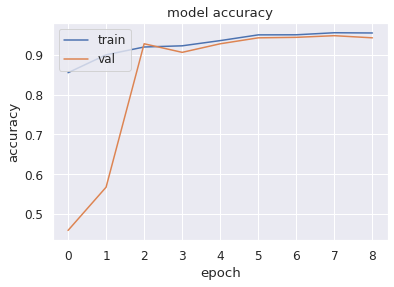

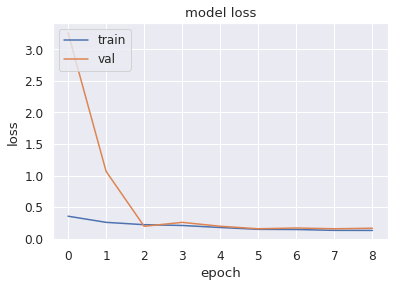

In [ ]:
plt.plot(history_CON.history['accuracy'])
plt.plot(history_CON.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_CON.history['loss'])
plt.plot(history_CON.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

img_width, img_height = 224, 224

def labels_confusion_matrix():
    folder_path="/content/drive/MyDrive/kaggle_all/test"
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):
            
            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(img_height, img_width))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):

    
    #cm_plot_labels = [i for i in range(20)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,class_map.keys(),class_map.keys())
    sns.set(font_scale=1.1) # for label size
    plt.figure(figsize = (12,9))
    s=sns.heatmap(df_cm, annot=True,cmap = 'viridis',fmt='g') # font size
    bottom,top=s.get_ylim()
    s.set_ylim(bottom+0.6,top-0.6)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

1/1 [==============================] - 0s 29ms/step


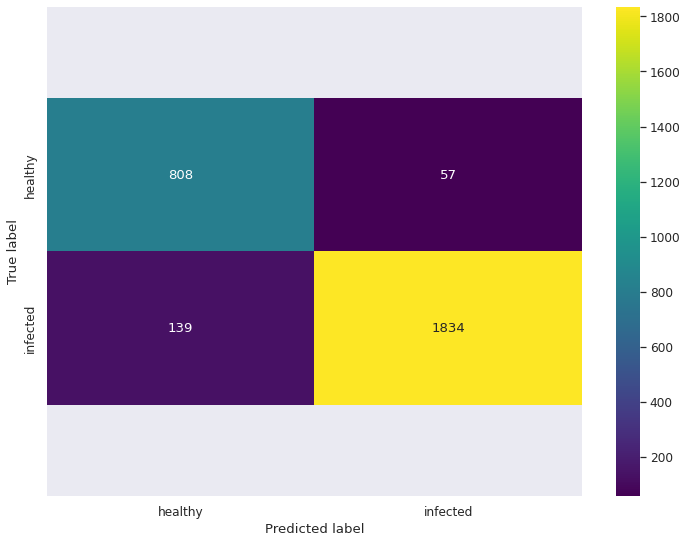

In [ ]:
class_map = train_CON.class_indices

y_true,y_pred=labels_confusion_matrix()
print_confusion_matrix(y_true,y_pred)

In [ ]:
from sklearn.metrics import classification_report

pred_aug = model.predict(test_CON)
pred_aug  = np.argmax(pred_aug, axis=1)
y_test_aug  = test_CON.labels
print(classification_report(y_test_aug, pred_aug))

89/89 [==============================] - 32s 339ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       865
           1       0.97      0.96      0.96      1973

    accuracy                           0.95      2838
   macro avg       0.94      0.94      0.94      2838
weighted avg       0.95      0.95      0.95      2838

